In [1]:
from fastai.vision.all import *

In [ ]:
#--------------------DATA--------------------#

In [10]:
path = untar_data(URLs.MNIST_SAMPLE) 

In [13]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()

three_tensors = [tensor(Image.open(o)) for o in threes]
seven_tensors = [tensor(Image.open(o)) for o in sevens]

stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255

valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255

valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255

In [14]:
#dataset
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1,28*28)
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
dset = list(zip(train_x, train_y))

#validation set
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [15]:
#separate dataloaders
dl  = DataLoader(dset, batch_size=256)
valid_dl = DataLoader(valid_dset, batch_size=256)

#main dataloader
dls = DataLoaders(dl, valid_dl)

In [19]:
#--------------------FUNCTIONS--------------------#

In [20]:
def init_params(size, std=1.0):
    return (torch.randn(size)*std).requires_grad_()

In [21]:
#sigmoid function
def sigmoid(x): 
    return 1/(1+torch.exp(-x))

In [22]:
#lost function with sigmoid
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [24]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [2]:
#--------------------NEURAL NETWORK--------------------#

In [3]:
#simple neural network
def simple_net(xb):
    res = xb@w1  + b1
    res = res.max(tensor(0.0)) #replace every negative number with 0
    res = res@w2 + b2
    return res

#it's basically two linear classifiers with a max in between them

In [16]:
#initializing parameters
w1 = init_params((28*28,30)) #w1 has 30 output activations
b1 = init_params(30)
w2 = init_params((30,1))     #w2 has 30 input  activations
b2 = init_params(1)

In [17]:
#neural network
simple_net = nn.Sequential(nn.Linear(28*28, 30),
                           nn.ReLU(), #non-linearity function
                           nn.Linear(30, 1))

#composition of two linear functions is another linear function, therefore
#to obtain a fit for complex function, non-linearity must be added

In [25]:
learn = Learner(dls, 
                simple_net, 
                opt_func=SGD,
                loss_func=mnist_loss, 
                metrics=batch_accuracy)

learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.287843,0.401118,0.507360,00:00
1,0.136446,0.219275,0.816977,00:00
2,0.077259,0.113268,0.917076,00:00
3,0.051792,0.077528,0.940137,00:00
4,0.039804,0.060929,0.956330,00:00
5,0.033574,0.051537,0.962218,00:00
6,0.029935,0.045585,0.965653,00:00
7,0.027540,0.041496,0.966634,00:00
8,0.025802,0.038499,0.968597,00:00
9,0.024451,0.036202,0.969087,00:00


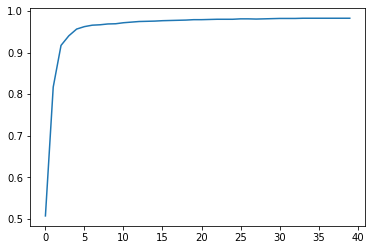

In [26]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [27]:
#--------------------18 LAYER NEURAL NETWORK--------------------#

In [ ]:
dls = ImageDataLoaders.from_folder(path)

learn = cnn_learner(dls,
                    resnet18,
                    pretrained=False,
                    loss_func=F.cross_entropy,
                    metrics=accuracy)

learn.fit_one_cycle(1, 0.1)